# Seperating stock to forcast for certain dates depending on the product

In [ ]:
%pip install nbformat

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [ ]:
# # import datasets and transformations (reusability purposes)
# from IPython import get_ipython

# get_ipython().run_line_magic('run', 'datasets.ipynb')

In [ ]:
import sys
sys.path.append('../src')

In [5]:
from data_config import ProductHandler as ph, feature_importance

/Users/mwilko777/Desktop/Project/Software Artifact/notebooks/../src/datasets.py:11: DtypeWarning: Columns (43,57,106,141,146,211,212,247,255,294,298,316,327,332,350,354) have mixed types. Specify dtype option on import or set low_memory=False.
  tickets_c_m = pd.read_csv(
/Users/mwilko777/Desktop/Project/Software Artifact/notebooks/../src/datasets.py:14: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  sp_inv_adds = pd.read_csv(


----- DROP BOOLEAN AND NULL COLUMNS (NOT NEEDED) -----

Merged Data - Columns to be dropped (Missing Vals): ['BackStage_DefaultReportForm', 'BackStage_SmartMarkSet', 'BillCounty', 'CoreType', 'EndUserNum', 'EndUserPO', 'Equip3_ID', 'Equip3_Status', 'Est_v_Act_Notes', 'Ink_Status', 'JDF_Note_to_DFE', 'JDF_Send_Msg', 'MiscChargeDesc1', 'MiscChargeDesc2', 'MiscChargeDesc3', 'MiscChargeDesc4', 'PlateStat', 'ProofStat', 'Roto_CEL_Product_ID', 'Roto_Quote_Line_ID', 'Roto_Quote_Number', 'Schedule_Status', 'ShipAttn_EmailAddress', 'ShipCounty', 'ShipStat', 'Tag_x', 'Tool3Descr', 'Tool4Descr', 'Tool5Descr', 'ToolNo3', 'ToolNo4', 'ToolNo5', 'ToolStat', 'UserDef_MR_1_Lb', 'UserDef_MR_2_Lb', 'Assigned', 'Desc2_x', 'ediLineNumber', 'eTraxx_Customer_Notes', 'Location_x', 'PO_Number', 'Adhesive', 'Alternate', 'eTraxx_Forecast_Range', 'Material', 'Tag_y', 'UPC']

Merged Data - Columns to be dropped (All cols with rows same vals): ['Act_OTHER_Hours', 'ActArtwork', 'ActFinMaterial', 'ActPostPressHours',

/Users/mwilko777/Desktop/Project/Software Artifact/notebooks/../src/datasets.py:101: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  merged_data['OrderDate'] = pd.to_datetime(
/Users/mwilko777/Desktop/Project/Software Artifact/notebooks/../src/datasets.py:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_data['OrderDate'] = pd.to_datetime(
/Users/mwilko777/Desktop/Project/Software Artifact/notebooks/../src/datasets.py:103: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.

In [6]:
ph.custom_prod_set()

All custom codes for existing products: 
{'BR-', '74X', '093', '772', 'EY-', '41Z', '814', 'KIM', 'UN-', 'LS-', '38Y', '24T', '22U', '695', '777', '996', '75Y', '97Y', '656', '42W', '96U', '602', '48X', '60R', '48U', '646', '43W', '4-0', '107', '05W', '95Y', 'PAC', 'IG-', '55T', '905', '198', 'HW-', 'Y-4', '200', '26V', '314', '643', '430', '47X', 'SE-', '775', '807', '928', 'US-', '977', '67Y', '768', 'COR', '689', '07T', '05X', '665', '657', '18W', '15S', '40S', '696', '08T', '34S', '007', '543', 'VO-', '813', '581', '28R', '997', 'RT-', '53X', '056', '71X', '820', '81Z', 'UND', '4Z-', '69U', '446', 'ODO', '04Y', '302', '439', '09X', '60Q', '36W', '989', '243', '660', 'EM-', 'WCW', 'GMU', 'UR-', '67V', '497', '11T', '478', '82X', '3Z-', '04X', '043', '00-', '818', '272', '90U', '642', '662', '876', '392', '88X', 'E-0', '19Y', 'TI-', '015', '77V', '036', '936', 'SBC', 'PK-', '831', '95W', 'RF-', '551', '304', '60T', '033', 'AUS', '29X', '431', '460', '742', '256', '96X', '62Y', '98W',

In [7]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# define the features and target variable from 'product_sales'
# CHANGE THE CUSTOMER CODE HERE >>>>>>>>>>
custom_code_df = pd.DataFrame(ph.get_custom_code_data('MOM'))

# customer code for later referencing
custom_ref = custom_code_df.loc[0, 'ProductNumber'][:3].lower().upper()
print(custom_ref)

custom_code_df.head()

MOM


,ProductNumber,order_year,order_month,order_week,order_weekday,is_weekend,Customer_Num,OrderQuantity,prev_month_sales,prev_week_sales,...,moving_avg_3m,moving_avg_6m,moving_avg_12m,moving_avg_18m,sales_2022,sales_2023,sales_2024,growth_2023,growth_2024,PhysicalInv
0,MOM-005-0018Z,2022,3,10,2,0,241.0,94500,117000.00000,117000.00000,...,105000.0,84000.0,84000.0,84000.0,94500,0,0,-100.0,NaN,0
1,MOM-005-0018Z,2022,3,13,0,0,241.0,117000,103500.00000,103500.00000,...,98500.0,81375.0,81375.0,81375.0,117000,0,0,-100.0,NaN,0
2,MOM-005-0018Z,2022,4,16,3,0,241.0,103500,75000.00000,75000.00000,...,69500.0,69500.0,69500.0,69500.0,103500,0,0,-100.0,NaN,0
3,MOM-005-0018Z,2023,10,40,3,0,241.0,75000,30000.00000,30000.00000,...,52500.0,52500.0,52500.0,52500.0,0,75000,0,inf,-100.0,0
4,MOM-005-0018Z,2024,1,2,4,0,241.0,30000,110031.53337,110031.53337,...,30000.0,30000.0,30000.0,30000.0,0,0,30000,NaN,inf,0


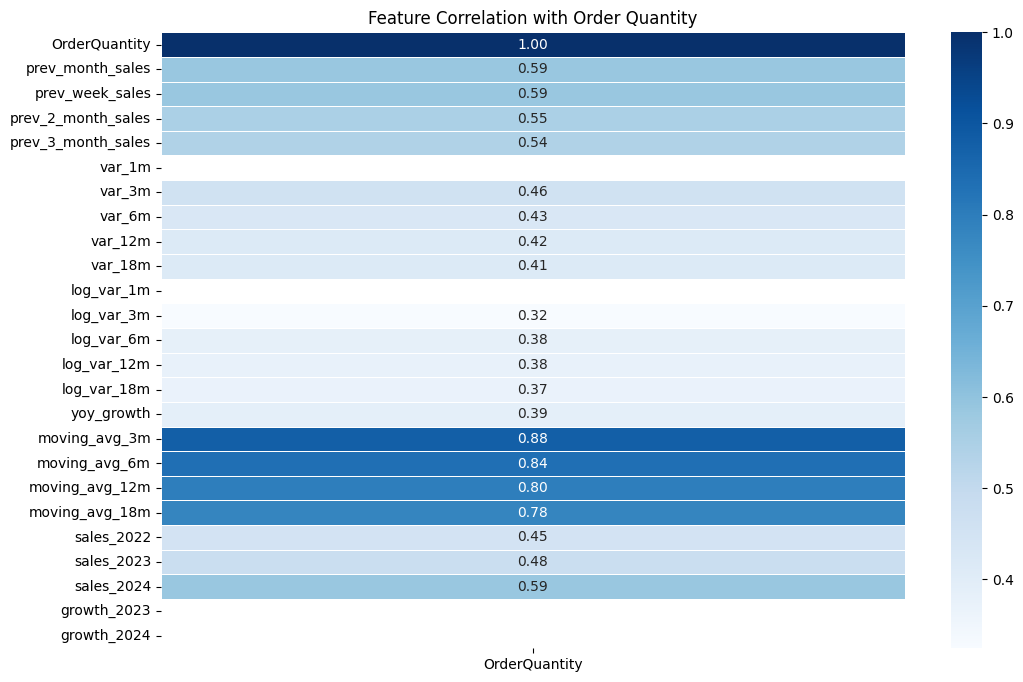

In [8]:
feature_importance(custom_code_df)

In [9]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
df = custom_code_df

features = ['ProductNumber', 'order_month',
            'prev_month_sales', 'prev_week_sales', 'prev_2_month_sales', 'prev_3_month_sales',
            'moving_avg_3m', 'moving_avg_6m', 'moving_avg_12m', 'moving_avg_18m',
            'var_3m', 'var_6m', 'var_12m', 'var_18m',
            'log_var_3m', 'log_var_6m', 'log_var_12m', 'log_var_18m',
            'yoy_growth', 'sales_2023', 'sales_2024'
            ]
target = 'OrderQuantity'

X = df[features]
y = df[target]

# one-hot encoding for categorical features
categorical_features = ['ProductNumber']
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# preprocessor (keeps numerical features as is)
preprocessor = ColumnTransformer(
    transformers=[
        # one-hot encode categorical features
        ('cat', encoder, categorical_features)
    ], remainder='passthrough'
)

# transform the features
X_transformed = preprocessor.fit_transform(X)


In [10]:
X_train, X_val, y_train, y_val = train_test_split(X_transformed, y, test_size=0.2, random_state=42)

# normalize data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [11]:
customer_total = df.copy()

# define features and target
features = ['ProductNumber', 'order_month', 'order_week', 'order_weekday',
            'prev_month_sales', 'prev_week_sales', 'prev_2_month_sales', 'prev_3_month_sales',
            'moving_avg_3m', 'moving_avg_6m', 'moving_avg_12m', 'moving_avg_18m',
            'var_3m', 'var_6m', 'var_12m', 'var_18m',
            'log_var_3m', 'log_var_6m', 'log_var_12m', 'log_var_18m',
            'yoy_growth', 'sales_2023', 'sales_2024'
           ]
target = 'OrderQuantity'

# filter the top products
total_X = customer_total[features]  # Features from top products
total_y = customer_total[target]    # Target variable

# define categorical and numeric features
categorical_features = ['ProductNumber']
numeric_features = list(set(features) - set(categorical_features))  # All other features are numeric

# Define transformations
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
scaler = StandardScaler()

# ColumnTransformer to apply transformations
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', encoder, categorical_features),   # One-hot encode categorical features
        ('num', scaler, numeric_features)        # Standardize numeric features
    ]
)

# Train-test split
total_X_train, total_X_val, total_y_train, total_y_val = train_test_split(total_X, total_y, test_size=0.2, random_state=42)

# Transform the features
total_X_train_transformed = preprocessor.fit_transform(total_X_train)
total_X_val_transformed = preprocessor.transform(total_X_val)

# Output the shape
print(f"Train Shape: {total_X_train_transformed.shape}, Validation Shape: {total_X_val_transformed.shape}")
print("Feature processing for top products completed successfully!")

customer_total.head()


Train Shape: (2179, 314), Validation Shape: (545, 314)
Feature processing for top products completed successfully!


,ProductNumber,order_year,order_month,order_week,order_weekday,is_weekend,Customer_Num,OrderQuantity,prev_month_sales,prev_week_sales,...,moving_avg_3m,moving_avg_6m,moving_avg_12m,moving_avg_18m,sales_2022,sales_2023,sales_2024,growth_2023,growth_2024,PhysicalInv
0,MOM-005-0018Z,2022,3,10,2,0,241.0,94500,117000.00000,117000.00000,...,105000.0,84000.0,84000.0,84000.0,94500,0,0,-100.0,NaN,0
1,MOM-005-0018Z,2022,3,13,0,0,241.0,117000,103500.00000,103500.00000,...,98500.0,81375.0,81375.0,81375.0,117000,0,0,-100.0,NaN,0
2,MOM-005-0018Z,2022,4,16,3,0,241.0,103500,75000.00000,75000.00000,...,69500.0,69500.0,69500.0,69500.0,103500,0,0,-100.0,NaN,0
3,MOM-005-0018Z,2023,10,40,3,0,241.0,75000,30000.00000,30000.00000,...,52500.0,52500.0,52500.0,52500.0,0,75000,0,inf,-100.0,0
4,MOM-005-0018Z,2024,1,2,4,0,241.0,30000,110031.53337,110031.53337,...,30000.0,30000.0,30000.0,30000.0,0,0,30000,NaN,inf,0


In [12]:
# the top 10 (or change) products by total actual order quantity
top_products = df.groupby('ProductNumber')['OrderQuantity'].sum().nlargest(1)

# extract top product code rows from the original df
top_prods_df = df[df['ProductNumber'].isin(top_products.index)]

# Extract top product numbers
top_product_numbers = top_products.index.tolist()  # List of top product numbers

top_prods_df.head()

unique_order_years = custom_code_df['order_year'].unique()
print(unique_order_years)

[2022 2023 2024 2025]


In [13]:
# define features and target
features = ['ProductNumber', 'order_month', 
            'prev_month_sales', 'prev_week_sales', 'prev_2_month_sales', 'prev_3_month_sales',
            'moving_avg_3m', 'moving_avg_6m', 'moving_avg_12m', 'moving_avg_18m',
            'var_3m', 'var_6m', 'var_12m', 'var_18m',
            'log_var_3m', 'log_var_6m', 'log_var_12m', 'log_var_18m',
            'yoy_growth', 'sales_2023', 'sales_2024'
           ]
target = 'OrderQuantity'

# filter the top products
tp_X = top_prods_df[features]  # Features from top products
tp_y = top_prods_df[target]    # Target variable

# define categorical and numeric features
categorical_features = ['ProductNumber']
numeric_features = list(set(features) - set(categorical_features))  # All other features are numeric

# Define transformations
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
scaler = StandardScaler()

# ColumnTransformer to apply transformations
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', encoder, categorical_features),   # One-hot encode categorical features
        ('num', scaler, numeric_features)        # Standardize numeric features
    ]
)

# Train-test split
tp_X_train, tp_X_val, tp_y_train, tp_y_val = train_test_split(tp_X, tp_y, test_size=0.2, random_state=42)

# Transform the features
tp_X_train_transformed = preprocessor.fit_transform(tp_X_train)
tp_X_val_transformed = preprocessor.transform(tp_X_val)

# Output the shape
print(f"Train Shape: {tp_X_train_transformed.shape}, Validation Shape: {tp_X_val_transformed.shape}")
print("Feature processing for top products completed successfully!")


Train Shape: (16, 21), Validation Shape: (5, 21)
Feature processing for top products completed successfully!


In [14]:
from sklearn.ensemble import RandomForestRegressor
from model_utils import find_best_hyperparameters, param_grids, evaluate_model

In [15]:
# train the model with scaled features (Random Forest Regressor)
rf = RandomForestRegressor()
rf_params = find_best_hyperparameters(rf, param_grids(rf.__class__.__name__), X_train_scaled, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV] END criterion=squared_error, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.6s
[CV] END criterion=squared_error, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.6s
[CV] END criterion=squared_error, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.6s
[CV] END criterion=squared_error, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.6s
[CV] END criterion=squared_error, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.7s
[CV] END criterion=squared_error, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.3s
[CV] END criterion=squared_error, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.3s
[CV] END criterion=squared_error, max_depth=5, min_samples_leaf=1, 

In [16]:
rf = RandomForestRegressor(**rf_params)
rf.fit(X_train_scaled, y_train)
y_pred_rf = rf.predict(X_val_scaled)

In [17]:
print('---------------------- TRAINING PERFORMANCE ----------------------')
evaluate_model(rf, X_train_scaled, y_train)
print('--------------------------------------------')

print('---------------------- TEST PERFORMANCE ----------------------')
evaluate_model(rf, X_val_scaled, y_val)
print('--------------------------------------------')

---------------------- TRAINING PERFORMANCE ----------------------
Evaluating model...
Model: RandomForestRegressor
Mean Absolute Error (MAE): 22745.1574
Mean Squared Error (MSE): 5948787930.2976
Root Mean Squared Error (RMSE): 77128.3860
R-squared (R²): 0.8779
--------------------------------------------
---------------------- TEST PERFORMANCE ----------------------
Evaluating model...
Model: RandomForestRegressor
Mean Absolute Error (MAE): 43757.4803
Mean Squared Error (MSE): 22857955980.5942
Root Mean Squared Error (RMSE): 151188.4783
R-squared (R²): 0.6176
--------------------------------------------


In [18]:
# train the model with scaled features (Random Forest Regressor) - TOTAL CUSTOM PRODUCTS IMPLEMENTATION
total_rf = RandomForestRegressor()
total_rf_params = find_best_hyperparameters(total_rf, param_grids(total_rf.__class__.__name__), total_X_train_transformed, total_y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV] END criterion=squared_error, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.6s
[CV] END criterion=squared_error, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.6s
[CV] END criterion=squared_error, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.6s
[CV] END criterion=squared_error, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.6s
[CV] END criterion=squared_error, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.7s
[CV] END criterion=squared_error, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.2s
[CV] END criterion=squared_error, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.2s
[CV] END criterion=squared_error, max_depth=5, min_samples_leaf=1, 

In [19]:
total_rf = RandomForestRegressor(**total_rf_params)
total_rf.fit(total_X_train_transformed, total_y_train)
total_y_pred_rf = total_rf.predict(total_X_val_transformed)

In [20]:
print('---------------------- TRAINING PERFORMANCE ----------------------')
evaluate_model(total_rf, total_X_train_transformed, total_y_train)
print('--------------------------------------------')

print('---------------------- TEST PERFORMANCE ----------------------')
evaluate_model(total_rf, total_X_val_transformed, total_y_val)
print('--------------------------------------------')

---------------------- TRAINING PERFORMANCE ----------------------
Evaluating model...
Model: RandomForestRegressor
Mean Absolute Error (MAE): 22801.3869
Mean Squared Error (MSE): 5723371375.3545
Root Mean Squared Error (RMSE): 75652.9667
R-squared (R²): 0.8825
--------------------------------------------
---------------------- TEST PERFORMANCE ----------------------
Evaluating model...
Model: RandomForestRegressor
Mean Absolute Error (MAE): 43612.2877
Mean Squared Error (MSE): 23814155109.1280
Root Mean Squared Error (RMSE): 154318.3564
R-squared (R²): 0.6016
--------------------------------------------


[19754.90331890332, 71892.84559884558, 279015.07936507935, 118995.5634920635, 24256.9600114436, 213361.93043068043, 99289.40476190476, 59569.21544715446, 39097.14285714286, 40072.75641025641, 60000.0, 24123.993500460885, 69135.6488095238, 26660.917606516286, 54940.27777777779, 29957.488095238095, 595035.4896825398, 40000.46875, 23532.466269841272, 229918.6626984127, 100435.73088023085, 19986.264023772772, 277677.5635209235, 7837.1558116883125, 115482.24603174606, 82254.6425363852, 11808.206666666667, 105749.1569264069, 190834.86904761905, 30654.941828481125, 90728.80952380951, 41324.160361473165, 28665.334138814287, 85652.17606846495, 284794.1825396826, 13776.28278132818, 40000.46875, 20026.69558287581, 170436.92142857146, 101367.01966089464, 178013.4563492064, 102788.97186147187, 136843.9816738817, 11106.23717288717, 144661.0753968254, 18137.785714285714, 38318.05224867726, 21611.359395109397, 32600.470238095248, 20254.548961206758, 31939.075396825392, 29212.22619047619, 59965.9446142

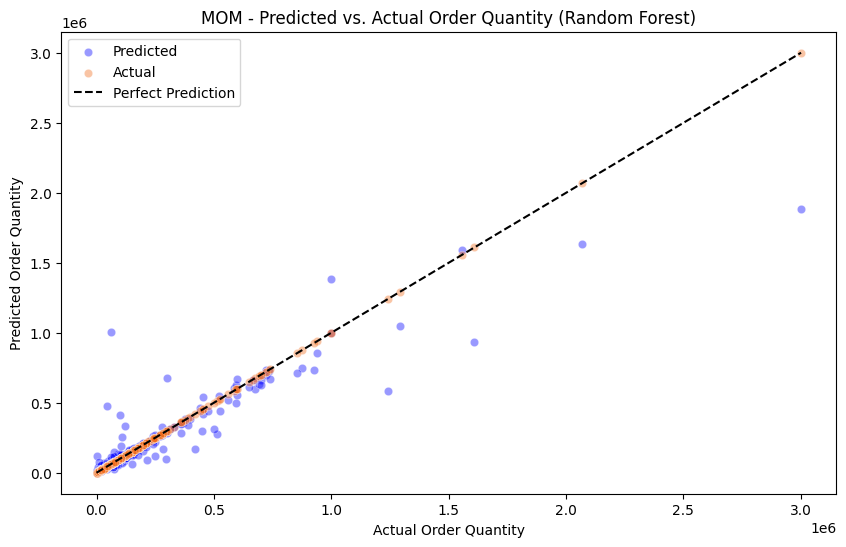

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

print(y_pred_rf.tolist())

plt.figure(figsize=(10, 6))

# scatter plot, actual vs predicted values
sns.scatterplot(x=y_val, y=y_pred_rf, alpha=0.4, color='blue', label='Predicted')  # Predicted values in blue

# actual values in red
sns.scatterplot(x=y_val, y=y_val, alpha=0.4, color='#f26d1d', label='Actual')

# reference line for perfect prediction
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], '--', color='black', label="Perfect Prediction")

plt.xlabel("Actual Order Quantity")
plt.ylabel("Predicted Order Quantity")
plt.title(f"{custom_ref} - Predicted vs. Actual Order Quantity (Random Forest)")
plt.legend()

plt.show()

/var/folders/31/9bd8ksys1rzbjk8qs9scl95h0000gn/T/ipykernel_10082/1606837329.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_prods_df['OrderDate'] = pd.to_datetime(top_prods_df[['order_year', 'order_month']].astype(str).agg('-'.join, axis=1))


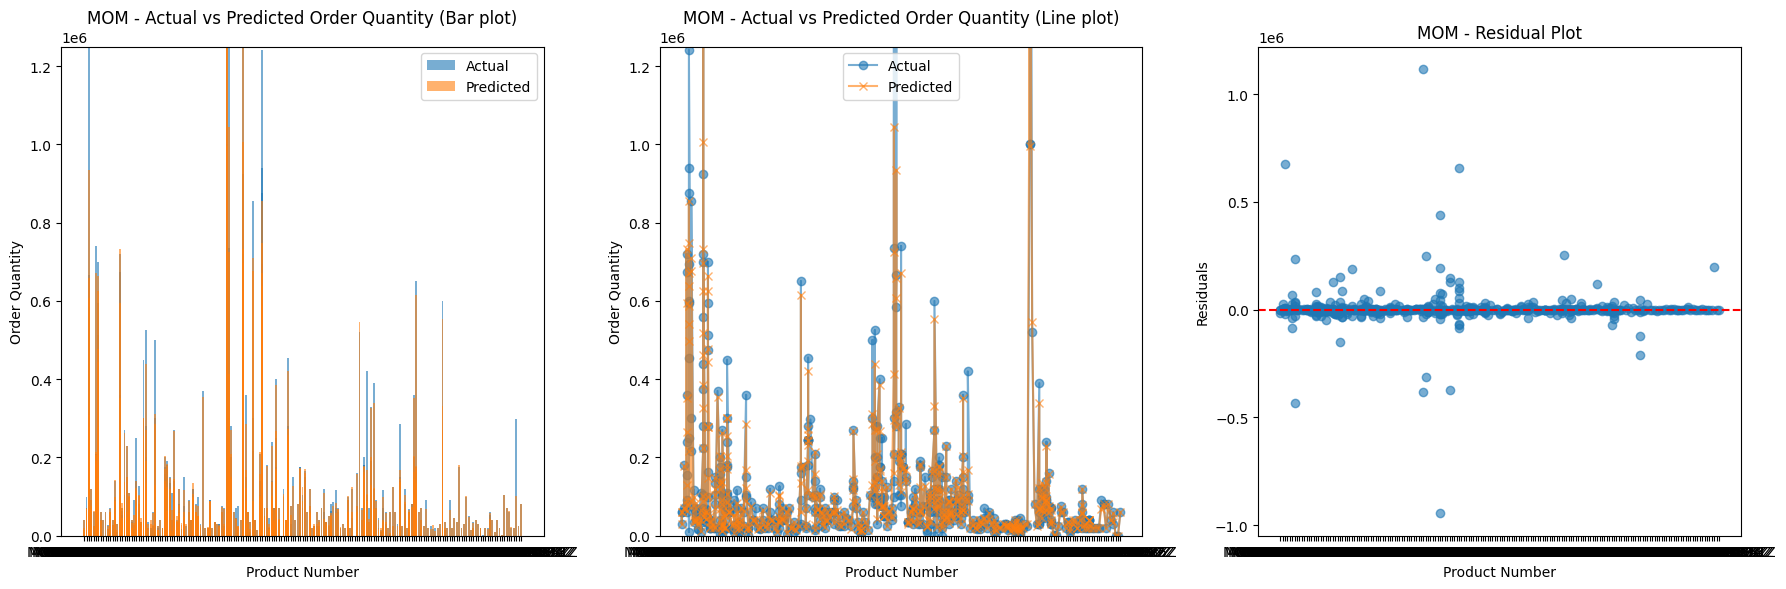

In [25]:
# Convert order year and month to datetime format
top_prods_df['OrderDate'] = pd.to_datetime(top_prods_df[['order_year', 'order_month']].astype(str).agg('-'.join, axis=1))

# Sort by OrderDate to maintain time order
top_prods_df = top_prods_df.sort_values(by='OrderDate')

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

# Bar plot, actual and predicted values over time
axes[0].bar(df.loc[y_val.index, 'ProductNumber'], y_val, label='Actual', alpha=0.6)
axes[0].bar(df.loc[y_val.index, 'ProductNumber'], y_pred_rf, label='Predicted', alpha=0.6)
axes[0].set_xlabel('Product Number')
axes[0].set_ylabel('Order Quantity')
axes[0].set_title(f'{custom_ref} - Actual vs Predicted Order Quantity (Bar plot)')
axes[0].set_ylim(0, 1250000)
axes[0].legend()

# Line plot, actual and predicted values
sorted_indices = df.loc[y_val.index, 'ProductNumber'].argsort()
sorted_products = df.loc[y_val.index, 'ProductNumber'].iloc[sorted_indices]
sorted_actual = y_val.iloc[sorted_indices]
sorted_predicted = y_pred_rf[sorted_indices]

axes[1].plot(sorted_products, sorted_actual, label='Actual', alpha=0.6, marker='o')
axes[1].plot(sorted_products, sorted_predicted, label='Predicted', alpha=0.6, marker='x')
axes[1].set_xlabel('Product Number')
axes[1].set_ylabel('Order Quantity')
axes[1].set_title(f'{custom_ref} - Actual vs Predicted Order Quantity (Line plot)')
axes[1].set_ylim(0, 1250000)
axes[1].legend()

# Residual plot
residuals = y_val - y_pred_rf
axes[2].scatter(df.loc[y_val.index, 'ProductNumber'], residuals, alpha=0.6)
axes[2].axhline(y=0, color='r', linestyle='--')
axes[2].set_xlabel('Product Number')
axes[2].set_ylabel('Residuals')
axes[2].set_title(f'{custom_ref} - Residual Plot')

plt.tight_layout()
plt.show()


In [26]:
# Convert order year and month to datetime format
customer_total['OrderDate'] = pd.to_datetime(customer_total[['order_year', 'order_month']].astype(str).agg('-'.join, axis=1))

# Sort by OrderDate to maintain time order
customer_total = customer_total.sort_values(by='OrderDate')

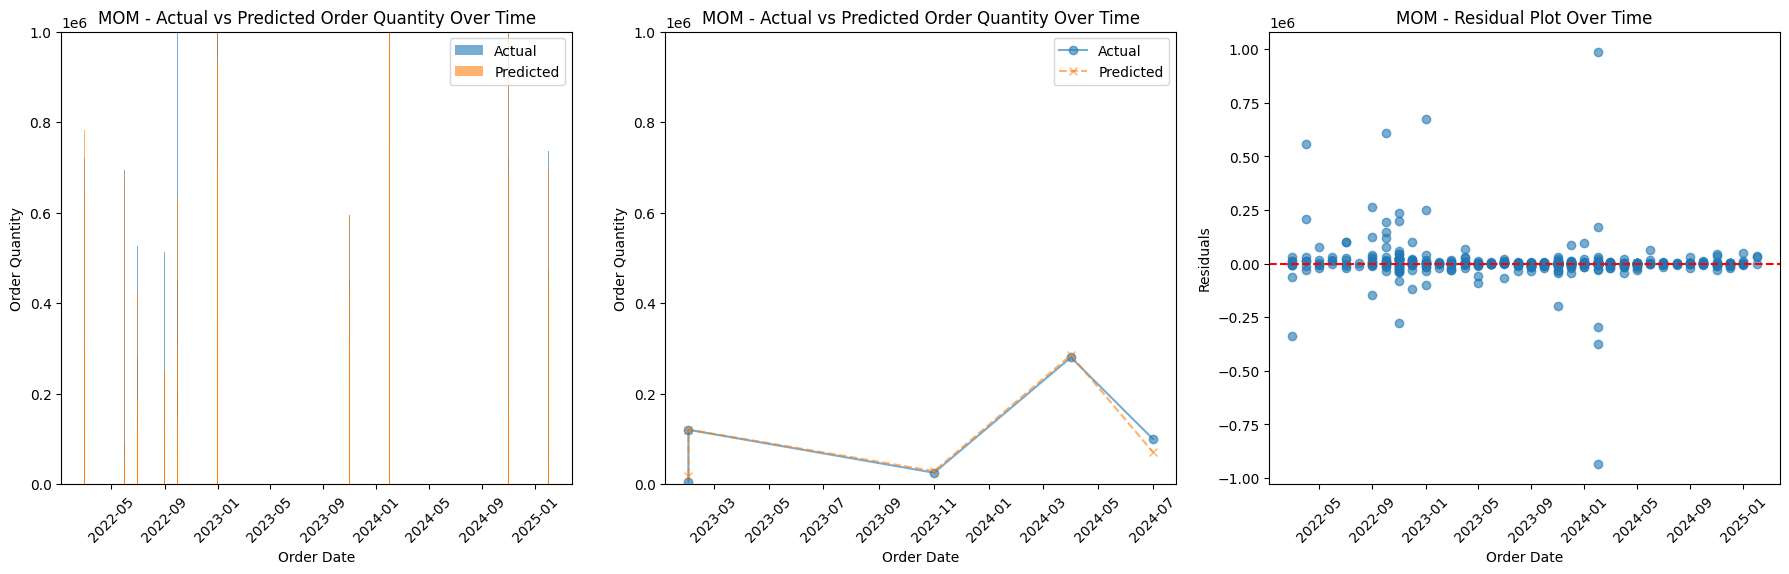

In [27]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

# Bar plot, actual and predicted values over time
axes[0].bar(customer_total.loc[total_y_val.index, 'OrderDate'], total_y_val, label='Actual', alpha=0.6)
axes[0].bar(customer_total.loc[total_y_val.index, 'OrderDate'], total_y_pred_rf, label='Predicted', alpha=0.6)
axes[0].set_xlabel('Order Date')
axes[0].set_ylabel('Order Quantity')
axes[0].set_title(f'{custom_ref} - Actual vs Predicted Order Quantity Over Time')
axes[0].set_ylim(0, 1000000)
axes[0].legend()
axes[0].tick_params(axis='x', rotation=45)  # Rotate x-axis labels for readability

# Line plot, actual and predicted values over time
sorted_indices = top_prods_df.loc[tp_y_val.index, 'OrderDate'].argsort()
sorted_dates = top_prods_df.loc[tp_y_val.index, 'OrderDate'].iloc[sorted_indices]
sorted_actual = total_y_val.iloc[sorted_indices]
sorted_predicted = total_y_pred_rf[sorted_indices]

axes[1].plot(sorted_dates, sorted_actual, label='Actual', alpha=0.6, marker='o', linestyle='-')
axes[1].plot(sorted_dates, sorted_predicted, label='Predicted', alpha=0.6, marker='x', linestyle='--')
axes[1].set_xlabel('Order Date')
axes[1].set_ylabel('Order Quantity')
axes[1].set_title(f'{custom_ref} - Actual vs Predicted Order Quantity Over Time')
axes[1].set_ylim(0, 1000000)
axes[1].legend()
axes[1].tick_params(axis='x', rotation=45)

# Residual plot over time
residuals = total_y_val - total_y_pred_rf
axes[2].scatter(customer_total.loc[total_y_val.index, 'OrderDate'], residuals, alpha=0.6)
axes[2].axhline(y=0, color='r', linestyle='--')
axes[2].set_xlabel('Order Date')
axes[2].set_ylabel('Residuals')
axes[2].set_title(f'{custom_ref} - Residual Plot Over Time')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [28]:
# # to see dataframe structure
# customer_total.head()


In [29]:
# # to see prediction nparray structure
# total_y_pred_rf

In [30]:
# # Group data by OrderDate and sum the relevant numerical columns
# customer_total = top_prods_df.groupby('OrderDate').sum(numeric_only=True).reset_index()

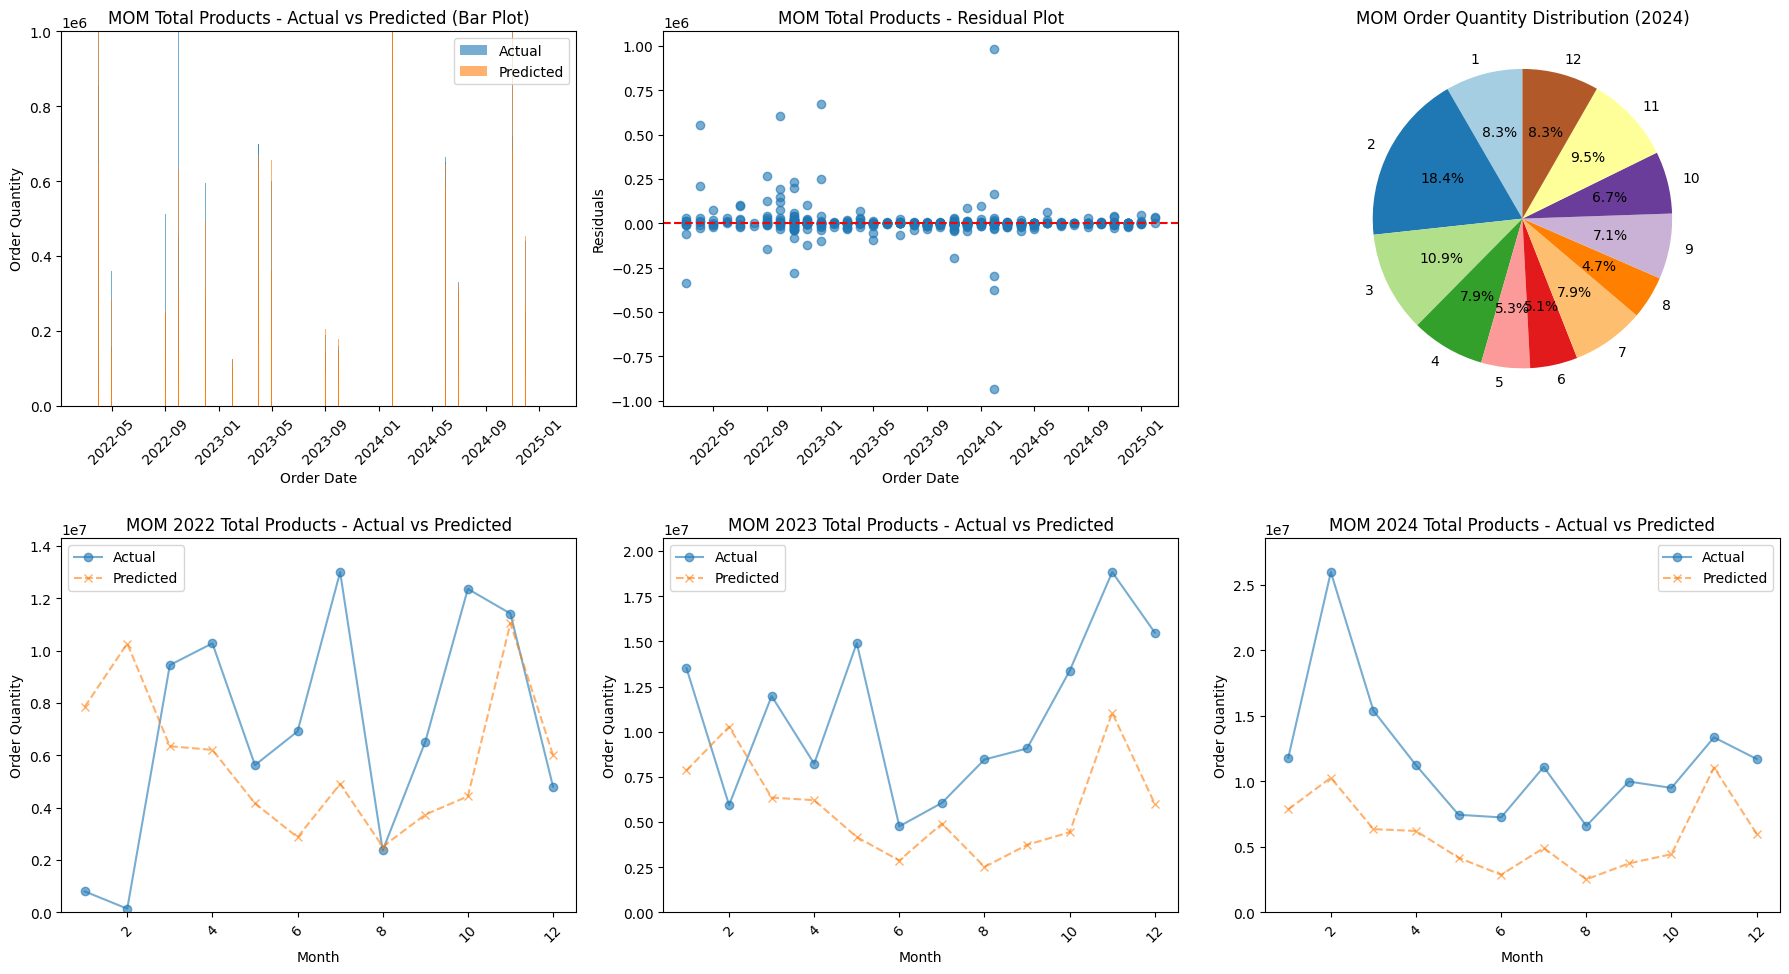

In [31]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
fig.subplots_adjust(hspace=0.4, wspace=0.3)  # Adjust layout for better spacing

# Bar plot: Actual vs. Predicted Order Quantity
axes[0, 0].bar(customer_total.loc[total_y_val.index, 'OrderDate'], total_y_val, label='Actual', alpha=0.6)
axes[0, 0].bar(customer_total.loc[total_y_val.index, 'OrderDate'], total_y_pred_rf, label='Predicted', alpha=0.6)
axes[0, 0].set_xlabel('Order Date')
axes[0, 0].set_ylabel('Order Quantity')
axes[0, 0].set_title(f'{custom_ref} Total Products - Actual vs Predicted (Bar Plot)')
axes[0, 0].set_ylim(0, 1_000_000)
axes[0, 0].legend()
axes[0, 0].tick_params(axis='x', rotation=45)

# Residual Plot
residuals = total_y_val - total_y_pred_rf
axes[0, 1].scatter(customer_total.loc[total_y_val.index, 'OrderDate'], residuals, alpha=0.6)
axes[0, 1].axhline(y=0, color='r', linestyle='--')
axes[0, 1].set_xlabel('Order Date')
axes[0, 1].set_ylabel('Residuals')
axes[0, 1].set_title(f'{custom_ref} Total Products - Residual Plot')
axes[0, 1].tick_params(axis='x', rotation=45)

# Pie Chart: Order Quantity per Month (2024)
order_2024 = customer_total[customer_total['order_year'] == 2024].groupby('order_month')['OrderQuantity'].sum()
axes[0, 2].pie(order_2024, labels=order_2024.index, autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors)
axes[0, 2].set_title(f'{custom_ref} Order Quantity Distribution (2024)')

# Line Plots: Yearly Trends
for i, year in enumerate([2022, 2023, 2024]):  
    yearly_df = customer_total[customer_total['order_year'] == year]

    if yearly_df.empty:
        continue  # skip if no data for that year

    # Aggregate OrderQuantity per month
    monthly_actual = yearly_df.groupby('order_month')['OrderQuantity'].sum()

    # Convert total_y_pred_rf to Pandas Series with index from customer_total
    pred_series = pd.Series(total_y_pred_rf, index=total_y_val.index)

    # Group predictions by month
    monthly_predicted = pred_series.groupby(customer_total.loc[total_y_val.index, 'order_month']).sum()

    # Sort for proper plotting
    monthly_actual = monthly_actual.sort_index()
    monthly_predicted = monthly_predicted.reindex(monthly_actual.index)  # Ensure same months

    # Plot actual and predicted values for the year
    axes[1, i].plot(monthly_actual.index, monthly_actual, label='Actual', alpha=0.6, marker='o', linestyle='-')
    axes[1, i].plot(monthly_predicted.index, monthly_predicted, label='Predicted', alpha=0.6, marker='x', linestyle='--')

    axes[1, i].set_xlabel('Month')
    axes[1, i].set_ylabel('Order Quantity')
    axes[1, i].set_title(f'{custom_ref} {year} Total Products - Actual vs Predicted')
    axes[1, i].set_ylim(0, max(monthly_actual.max(), monthly_predicted.max()) * 1.1)  # Scale Y axis
    axes[1, i].legend()
    axes[1, i].tick_params(axis='x', rotation=45)

# Adjust layout for better spacing between subplots
plt.tight_layout()
plt.show()


In [32]:
has_orders_2022 = not customer_total[customer_total['order_year'] == 2022].empty
print(f"Orders in 2022 exist: {has_orders_2022}")


Orders in 2022 exist: True


In [33]:
customer_total.head(10)

,ProductNumber,order_year,order_month,order_week,order_weekday,is_weekend,Customer_Num,OrderQuantity,prev_month_sales,prev_week_sales,...,moving_avg_6m,moving_avg_12m,moving_avg_18m,sales_2022,sales_2023,sales_2024,growth_2023,growth_2024,PhysicalInv,OrderDate
2696,MOM-TRL-0001Z,2022,1,5,0,0,241.0,378000,1.100315e+05,1.100315e+05,...,378000.000000,378000.000000,378000.000000,378000,0,0,-100.0,NaN,0,2022-01-01
2699,MOM-TRL-0003Z,2022,1,5,0,0,241.0,157500,1.100315e+05,1.100315e+05,...,157500.000000,157500.000000,157500.000000,157500,0,0,-100.0,NaN,0,2022-01-01
2700,MOM-TRL-0004Z,2022,1,5,0,0,241.0,126000,1.100315e+05,1.100315e+05,...,126000.000000,126000.000000,126000.000000,126000,0,0,-100.0,NaN,0,2022-01-01
2697,MOM-TRL-0002Z,2022,1,5,0,0,241.0,140000,1.400000e+05,1.400000e+05,...,140000.000000,140000.000000,140000.000000,140000,0,0,-100.0,NaN,0,2022-01-01
2698,MOM-TRL-0002Z,2022,2,7,0,0,241.0,140000,1.100315e+05,1.100315e+05,...,140000.000000,140000.000000,140000.000000,140000,0,0,-100.0,NaN,0,2022-02-01
33,MOM-005-0021Z,2022,3,10,2,0,241.0,120000,4.000000e+04,4.000000e+04,...,75333.333333,70285.714286,70285.714286,120000,0,0,-100.0,NaN,120000,2022-03-01
163,MOM-005-0027Z,2022,3,13,0,0,241.0,63000,7.200000e+04,7.200000e+04,...,82166.666667,75916.666667,73153.846154,63000,0,0,-100.0,NaN,70000,2022-03-01
553,MOM-005-0047Z,2022,3,10,2,0,241.0,90000,2.700000e+04,2.700000e+04,...,60000.000000,48333.333333,39444.444444,90000,0,0,-100.0,NaN,30000,2022-03-01
554,MOM-005-0047Z,2022,3,13,0,0,241.0,27000,3.600000e+04,3.600000e+04,...,53333.333333,42500.000000,35555.555556,27000,0,0,-100.0,NaN,30000,2022-03-01
262,MOM-005-0032Z,2022,3,13,0,0,241.0,904500,1.188000e+06,1.188000e+06,...,596250.000000,500375.000000,384861.111111,904500,0,0,-100.0,NaN,1005000,2022-03-01


In [34]:
# from powerbiclient import QuickVisualize, get_dataset_config, Report
# from powerbiclient.authentication import InteractiveLoginAuthentication, DeviceCodeLoginAuthentication
# import pandas as pd

# prod_sales = pd.read_csv(
#     '/Users/mwilko777/Desktop/Project/Software Artifact/datasets/stock_forecasting/final/product_sales.csv')

# # use DeviceCodeLoginAuthentication if want to sign in each time, else InteractiveLoginAuthentication
# auth = InteractiveLoginAuthentication()
# print("Authentication successful.")


# def visual():
#     dataset_config = get_dataset_config(prod_sales)
#     return QuickVisualize(dataset_config, auth)

# visual()

In [35]:
customer_total.head()

,ProductNumber,order_year,order_month,order_week,order_weekday,is_weekend,Customer_Num,OrderQuantity,prev_month_sales,prev_week_sales,...,moving_avg_6m,moving_avg_12m,moving_avg_18m,sales_2022,sales_2023,sales_2024,growth_2023,growth_2024,PhysicalInv,OrderDate
2696,MOM-TRL-0001Z,2022,1,5,0,0,241.0,378000,110031.53337,110031.53337,...,378000.0,378000.0,378000.0,378000,0,0,-100.0,NaN,0,2022-01-01
2699,MOM-TRL-0003Z,2022,1,5,0,0,241.0,157500,110031.53337,110031.53337,...,157500.0,157500.0,157500.0,157500,0,0,-100.0,NaN,0,2022-01-01
2700,MOM-TRL-0004Z,2022,1,5,0,0,241.0,126000,110031.53337,110031.53337,...,126000.0,126000.0,126000.0,126000,0,0,-100.0,NaN,0,2022-01-01
2697,MOM-TRL-0002Z,2022,1,5,0,0,241.0,140000,140000.00000,140000.00000,...,140000.0,140000.0,140000.0,140000,0,0,-100.0,NaN,0,2022-01-01
2698,MOM-TRL-0002Z,2022,2,7,0,0,241.0,140000,110031.53337,110031.53337,...,140000.0,140000.0,140000.0,140000,0,0,-100.0,NaN,0,2022-02-01


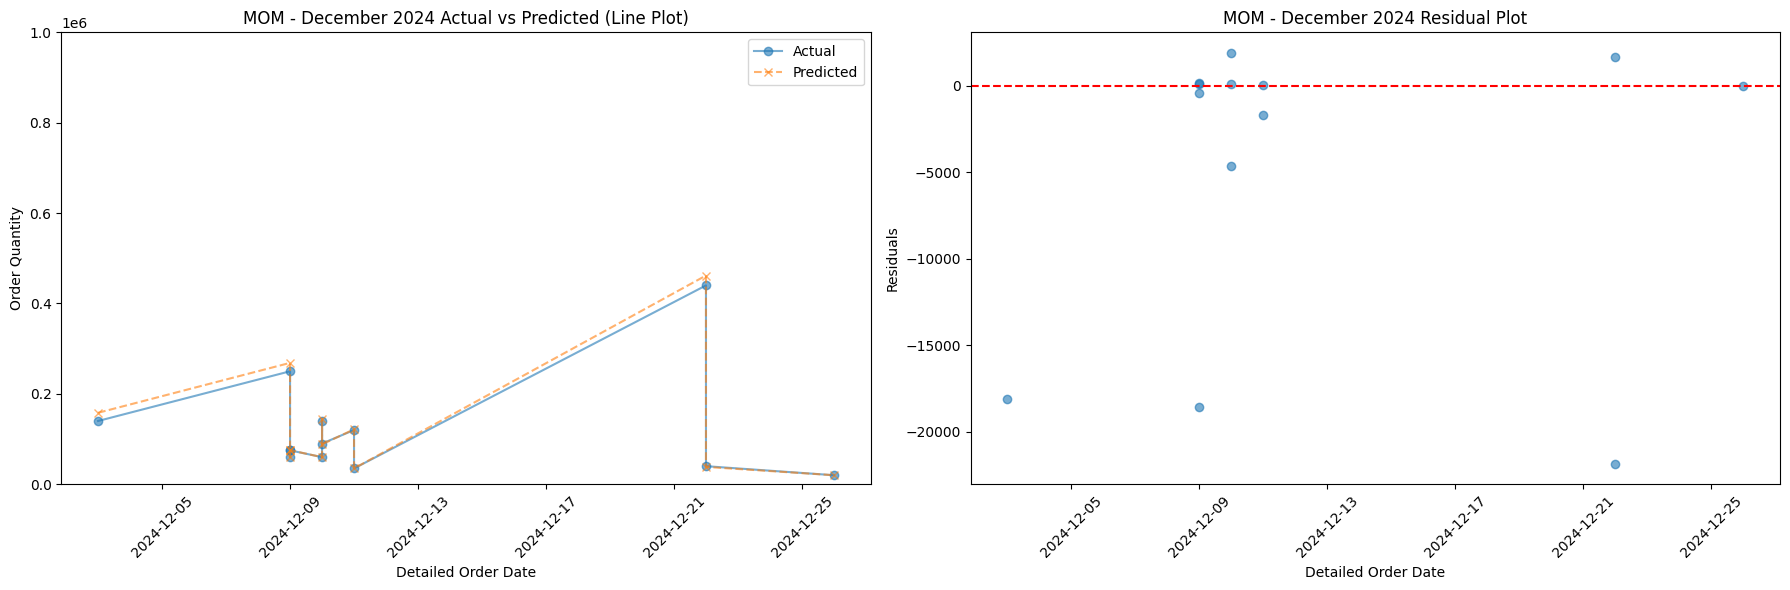

In [36]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Create a DetailedOrderDate column using week and weekday information.
# Adjust the format as needed based on your data.
customer_total['DetailedOrderDate'] = pd.to_datetime(
    customer_total['order_year'].astype(str) +
    customer_total['order_week'].astype(str).str.zfill(2) +
    customer_total['order_weekday'].astype(str),
    format='%Y%W%w'
)

# Filter the data for December 2024 using DetailedOrderDate
dec_2024_data = customer_total[
    (customer_total['DetailedOrderDate'].dt.year == 2024) &
    (customer_total['DetailedOrderDate'].dt.month == 12)
]

# Use only the common indices between dec_2024_data and y_val
common_index = dec_2024_data.index.intersection(y_val.index)
dec_2024_actual = y_val.loc[common_index]
# Convert y_pred_rf to a Series for indexing (using the same index as y_val)
y_pred_rf_series = pd.Series(y_pred_rf, index=y_val.index)
dec_2024_predicted = y_pred_rf_series.loc[common_index]

# --- Incorporate your provided sorting snippet, adapted for December 2024 data ---
# Here we sort by DetailedOrderDate from dec_2024_data for the common indices.
sorted_indices = dec_2024_data.loc[common_index, 'DetailedOrderDate'].argsort()
sorted_dates = dec_2024_data.loc[common_index, 'DetailedOrderDate'].iloc[sorted_indices]
sorted_actual = dec_2024_actual.iloc[sorted_indices]
sorted_predicted = dec_2024_predicted.iloc[sorted_indices]
# --- End of sorting snippet ---

# Create subplots (1 row, 2 columns: one for line plot, one for residual plot)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
fig.subplots_adjust(hspace=0.4, wspace=0.3)

# Line Plot: Actual vs. Predicted Order Quantity using DetailedOrderDate
axes[0].plot(sorted_dates, sorted_actual, label='Actual', alpha=0.6, marker='o', linestyle='-')
axes[0].plot(sorted_dates, sorted_predicted, label='Predicted', alpha=0.6, marker='x', linestyle='--')
axes[0].set_xlabel('Detailed Order Date')
axes[0].set_ylabel('Order Quantity')
axes[0].set_title(f'{custom_ref} - December 2024 Actual vs Predicted (Line Plot)')
axes[0].set_ylim(0, 1_000_000)
axes[0].legend()
axes[0].tick_params(axis='x', rotation=45)

# Residual Plot for December 2024
residuals_dec_2024 = sorted_actual - sorted_predicted
axes[1].scatter(sorted_dates, residuals_dec_2024, alpha=0.6)
axes[1].axhline(y=0, color='r', linestyle='--')
axes[1].set_xlabel('Detailed Order Date')
axes[1].set_ylabel('Residuals')
axes[1].set_title(f'{custom_ref} - December 2024 Residual Plot')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()
